### Getting location Coordinates

In [1]:
from geopy.geocoders import Nominatim

In [3]:
geolocator = Nominatim(user_agent='weather_forecast')

In [4]:
city = input("Please Enter the city name correctly: \n")

Please Enter the city name correctly: 
 Hyderabad


In [8]:
location = geolocator.geocode(f"{city}, India")

In [11]:
if location==None:
    print(f"Location {city} Not found. Please enter correct city name\n")
else:
    lat = location.latitude
    print(f'Latitude: {location.latitude}')
    long = location.longitude
    print(f'Longitude: {location.longitude}')

Latitude: 17.360589
Longitude: 78.4740613


### Getting historical data

In [13]:
from datetime import timedelta, datetime

In [15]:
end = datetime.today() - timedelta(days=1)

In [16]:
end

datetime.datetime(2025, 6, 21, 18, 3, 52, 141886)

In [18]:
start = end.replace(year=end.year-10)

In [19]:
start

datetime.datetime(2015, 6, 21, 18, 3, 52, 141886)

In [23]:
from meteostat import Daily, Point
import pandas as pd

In [24]:
loc = Point(lat, long)

In [26]:
data = Daily(loc, start, end)

In [28]:
df = data.fetch()

In [29]:
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2015-06-22,27.0,22.5,<NA>,8.9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2015-06-23,29.0,23.8,33.6,0.3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2015-06-24,28.6,24.6,33.6,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2015-06-25,29.0,24.9,33.9,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2015-06-26,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [34]:
df = df[['tavg', 'prcp']]

In [35]:
df.head()

,tavg,prcp
time,,
2015-06-22,27.0,8.9
2015-06-23,29.0,0.3
2015-06-24,28.6,0.0
2015-06-25,29.0,0.0
2015-06-26,<NA>,<NA>


In [36]:
df.isna().sum()

tavg     268
prcp    1375
dtype: int64

In [37]:
df['tavg'] = df['tavg'].interpolate(method='time')

In [38]:
df.isna().sum()

tavg       0
prcp    1375
dtype: int64

In [39]:
df.dropna(subset=['prcp'], inplace=True)

In [41]:
df.isna().sum()

tavg    0
prcp    0
dtype: int64

In [42]:
df.shape

(2278, 2)

### STL decomposition

In [44]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

In [45]:
df_t = df[['tavg']]

In [46]:
df_t.head()

,tavg
time,
2015-06-22,27.0
2015-06-23,29.0
2015-06-24,28.6
2015-06-25,29.0
2015-06-30,29.6


In [48]:
stl = STL(df_t, period=365)
result = stl.fit()

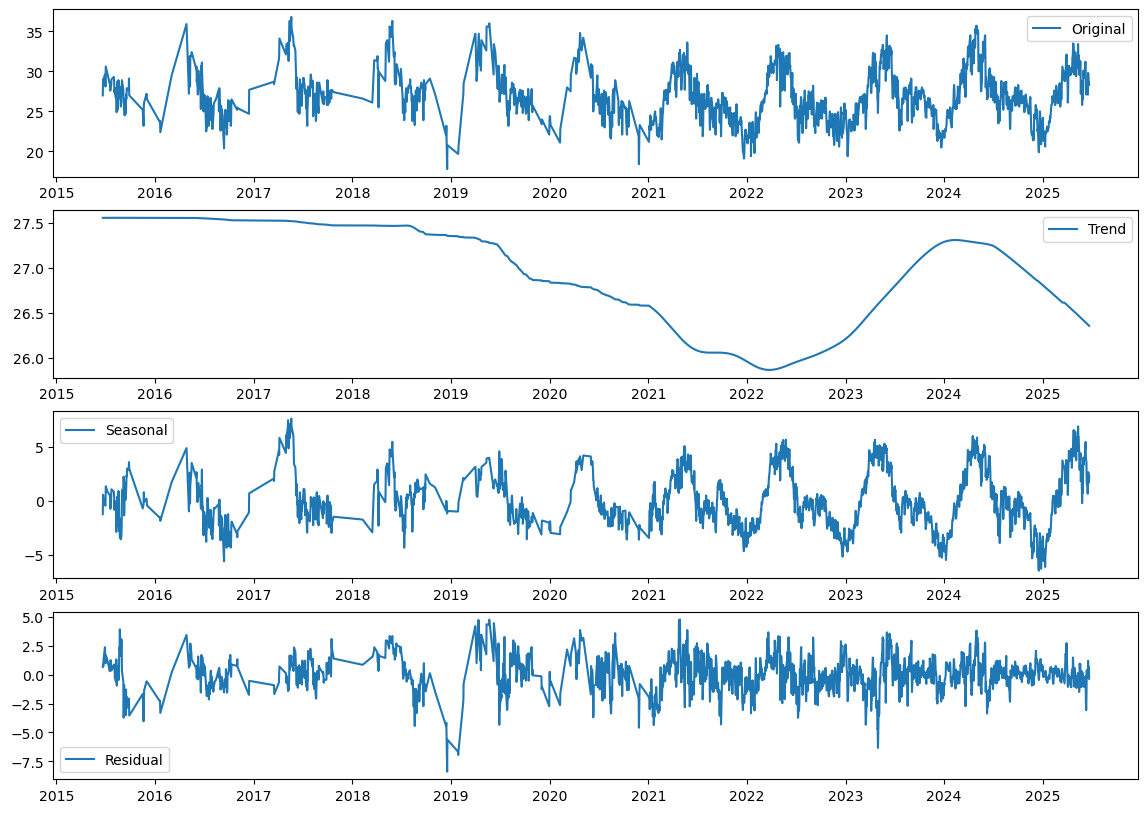

In [49]:
plt.figure(figsize=(14,10))

plt.subplot(411)
plt.plot(df_t, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()

In [50]:
df_p = df[['prcp']]

In [52]:
stl_r = STL(df_p, period=365)
result_r = stl_r.fit()

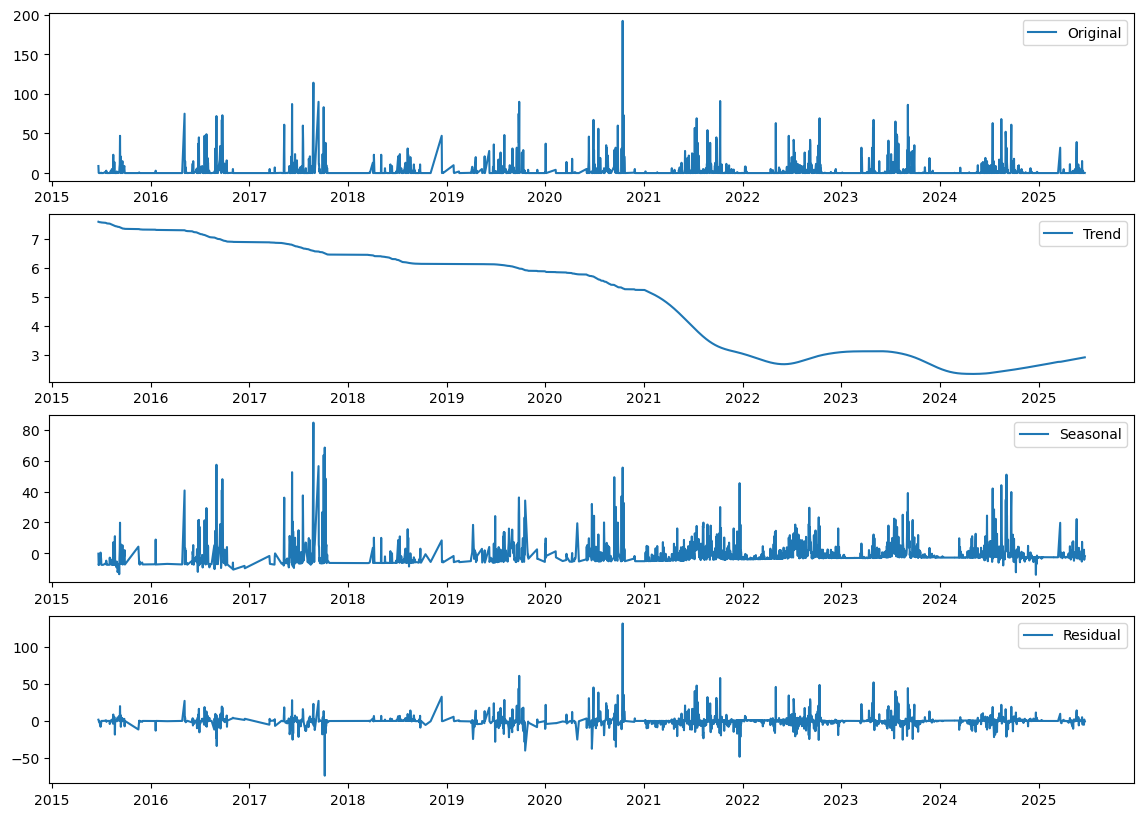

In [53]:
plt.figure(figsize=(14,10))

plt.subplot(411)
plt.plot(df_p, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(result_r.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(result_r.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result_r.resid, label='Residual')
plt.legend()

### Stationarity Test

In [61]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [57]:
def adf(series):
    adf_test = adfuller(series)
    print("ADF Statistic:", round(adf_test[0],3))
    print("P value:", round(adf_test[1],3))
    print("Critical values\n")
    for key, value in adf_test[4].items():
        print(f'{key}:{round(value,3)}')

In [58]:
adf(df_t)

ADF Statistic: -5.998
P value: 0.0
Critical values

1%:-3.433
5%:-2.863
10%:-2.567


In [60]:
adf(df_p)

ADF Statistic: -8.033
P value: 0.0
Critical values

1%:-3.433
5%:-2.863
10%:-2.567


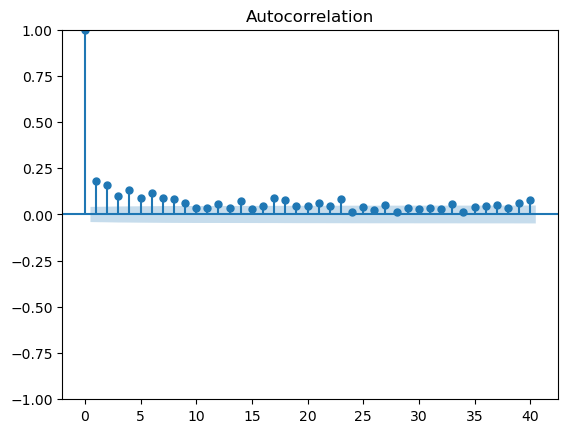

In [64]:
 _ = plot_acf(df['prcp'], lags=40)

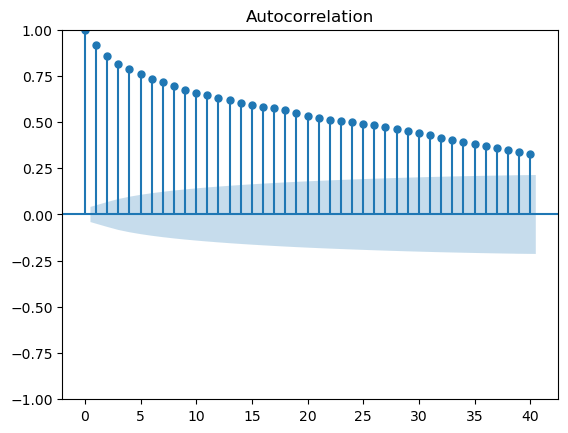

In [65]:
_ = plot_acf(df['tavg'], lags=40)

In [66]:
df['tavg_365'] = df['tavg'].shift(365)
df['prcp_365'] = df['prcp'].shift(365)

In [67]:
df.head()

,tavg,prcp,tavg_365,prcp_365
time,,,,
2015-06-22,27.0,8.9,<NA>,<NA>
2015-06-23,29.0,0.3,<NA>,<NA>
2015-06-24,28.6,0.0,<NA>,<NA>
2015-06-25,29.0,0.0,<NA>,<NA>
2015-06-30,29.6,0.0,<NA>,<NA>


In [68]:
df.tail()

,tavg,prcp,tavg_365,prcp_365
time,,,,
2025-06-17,29.8,0.0,26.5,0.3
2025-06-18,29.7,0.0,27.3,14.0
2025-06-19,28.9,0.5,28.2,0.0
2025-06-20,28.7,0.4,26.7,0.5
2025-06-21,28.3,0.2,28.4,2.0


### Model

In [69]:
df.isna().sum()

tavg          0
prcp          0
tavg_365    365
prcp_365    365
dtype: int64

In [70]:
df2 = df.copy()

In [72]:
df2.dtypes

tavg        Float64
prcp        Float64
tavg_365    Float64
prcp_365    Float64
dtype: object

In [73]:
df2 = df2.astype('float')

In [75]:
df2.dtypes

tavg        float64
prcp        float64
tavg_365    float64
prcp_365    float64
dtype: object

In [76]:
df2 = df2.asfreq('D')

In [77]:
df2.shape

(3653, 4)

In [78]:
df2.index.freq

<Day>

In [81]:
df2.isna().sum()

tavg        1375
prcp        1375
tavg_365    1740
prcp_365    1740
dtype: int64

In [84]:
df2['tavg'] = df2['tavg'].interpolate(method='time')
df2['prcp'] = df2['prcp'].interpolate(method='time')

In [86]:
df2['tavg_365'] = df2['tavg'].shift(365)

In [87]:
df2['prcp_365'] = df2['prcp'].shift(365)

In [88]:
df2.isna().sum()

tavg          0
prcp          0
tavg_365    365
prcp_365    365
dtype: int64

In [89]:
df2

,tavg,prcp,tavg_365,prcp_365
time,,,,
2015-06-22,27.00,8.9,NaN,NaN
2015-06-23,29.00,0.3,NaN,NaN
2015-06-24,28.60,0.0,NaN,NaN
2015-06-25,29.00,0.0,NaN,NaN
2015-06-26,29.12,0.0,NaN,NaN
...,...,...,...,...
2025-06-17,29.80,0.0,28.2,0.0
2025-06-18,29.70,0.0,30.4,19.1
2025-06-19,28.90,0.5,29.4,0.0


In [91]:
df_model = df2.dropna()

In [93]:
df_model.isna().sum()

tavg        0
prcp        0
tavg_365    0
prcp_365    0
dtype: int64

In [94]:
from statsmodels.tsa.api import VAR

In [95]:
model = VAR(df_model)

In [97]:
lag_selection = model.select_order(maxlags=40)

In [98]:
lag_selection.summary()

,AIC,BIC,FPE,HQIC
0,13.44,13.45,6.868e+05,13.44
1,8.462,8.500,4733.,8.476
2,8.326,8.393,4129.,8.350
3,8.302,8.399,4031.,8.337
4,8.248*,8.375*,3819.*,8.293*
5,8.253,8.411,3840.,8.310
6,8.253,8.441,3841.,8.321
7,8.250,8.467,3828.,8.328
8,8.249,8.497,3825.,8.338
9,8.257,8.534,3854.,8.356


In [99]:
model_fitted = model.fit(4)

In [101]:
forecast_steps = 7

In [103]:
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Jun, 2025
Time:                     19:21:13
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    8.38001
Nobs:                     3284.00    HQIC:                   8.29897
Log likelihood:          -32123.9    FPE:                    3842.06
AIC:                      8.25376    Det(Omega_mle):         3763.53
--------------------------------------------------------------------
Results for equation tavg
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.435034         0.141332            3.078           0.002
L1.tavg             0.891066         0.017775           50.130           0.000
L1.prcp             0.004768         0.001702            2.801       

In [108]:
forecast = model_fitted.forecast(df_model.values[-4:], steps=forecast_steps)

In [109]:
forecast

array([[28.38260723,  2.62221484, 28.46015424,  6.90545993],
       [28.46387133,  1.90754713, 28.53495771,  2.93093193],
       [28.45015664,  2.09865531, 28.62584332,  3.36216323],
       [28.4107732 ,  2.43246107, 28.55802873,  2.49449079],
       [28.37714801,  2.90300042, 28.52730427,  3.67905092],
       [28.36297348,  2.93797694, 28.50576872,  3.17715022],
       [28.34433665,  3.02405867, 28.49550865,  3.32337654]])

In [110]:
last_date = df_model.index[-1]

In [111]:
last_date

Timestamp('2025-06-21 00:00:00')

In [112]:
forecast_df = pd.DataFrame(forecast, columns=df_model.columns)

In [113]:
forecast_df

,tavg,prcp,tavg_365,prcp_365
0,28.382607,2.622215,28.460154,6.905460
1,28.463871,1.907547,28.534958,2.930932
2,28.450157,2.098655,28.625843,3.362163
3,28.410773,2.432461,28.558029,2.494491
4,28.377148,2.903000,28.527304,3.679051
5,28.362973,2.937977,28.505769,3.177150
6,28.344337,3.024059,28.495509,3.323377


In [117]:
forecast_df.index = pd.date_range(start = last_date+timedelta(days=1), periods=forecast_steps, freq='D')

In [118]:
forecast_df

,tavg,prcp,tavg_365,prcp_365
2025-06-22,28.382607,2.622215,28.460154,6.905460
2025-06-23,28.463871,1.907547,28.534958,2.930932
2025-06-24,28.450157,2.098655,28.625843,3.362163
2025-06-25,28.410773,2.432461,28.558029,2.494491
2025-06-26,28.377148,2.903000,28.527304,3.679051
2025-06-27,28.362973,2.937977,28.505769,3.177150
2025-06-28,28.344337,3.024059,28.495509,3.323377


### Rain Prediction

In [149]:
Rain = (df_model['prcp'] > 0.5).astype(int)
features = df_model[['tavg','tavg_365', 'prcp_365']]
features['Rain'] = Rain

In [150]:
X = df_model[['tavg','tavg_365', 'prcp_365']]

In [151]:
y = features['Rain']

In [152]:
features

,tavg,tavg_365,prcp_365,Rain
time,,,,
2016-06-21,30.7,27.00,8.9,0
2016-06-22,29.4,29.00,0.3,1
2016-06-23,31.1,28.60,0.0,0
2016-06-24,29.4,29.00,0.0,0
2016-06-25,28.5,29.12,0.0,0
...,...,...,...,...
2025-06-17,29.8,28.20,0.0,0
2025-06-18,29.7,30.40,19.1,0
2025-06-19,28.9,29.40,0.0,0


In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [156]:
gcv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [157]:
gcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [158]:
gcv.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [159]:
best_model = gcv.best_estimator_

In [160]:
y_pred = best_model.predict(X_test)

In [161]:
print(accuracy_score(y_test, y_pred))

0.7340425531914894


In [162]:
forecast_df.head()

,tavg,prcp,tavg_365,prcp_365,Rain
2025-06-22,28.382607,2.622215,28.460154,6.905460,0
2025-06-23,28.463871,1.907547,28.534958,2.930932,0
2025-06-24,28.450157,2.098655,28.625843,3.362163,0
2025-06-25,28.410773,2.432461,28.558029,2.494491,0
2025-06-26,28.377148,2.903000,28.527304,3.679051,0


In [163]:
forecast_df['Rain'] = best_model.predict(forecast_df[['tavg', 'tavg_365', 'prcp_365']])

In [165]:
forecast_df

,tavg,prcp,tavg_365,prcp_365,Rain
2025-06-22,28.382607,2.622215,28.460154,6.905460,0
2025-06-23,28.463871,1.907547,28.534958,2.930932,0
2025-06-24,28.450157,2.098655,28.625843,3.362163,0
2025-06-25,28.410773,2.432461,28.558029,2.494491,0
2025-06-26,28.377148,2.903000,28.527304,3.679051,0
2025-06-27,28.362973,2.937977,28.505769,3.177150,0
2025-06-28,28.344337,3.024059,28.495509,3.323377,0


In [179]:
print("*********************Next 7 days Forecast*******************")
forecast_final = forecast_df[['tavg', 'Rain']].copy()
forecast_final['Rain'] = forecast_final['Rain'].map({0:'No Rain', 1:'Rain'})
forecast_final

*********************Next 7 days Forecast*******************


,tavg,Rain
2025-06-22,28.382607,No Rain
2025-06-23,28.463871,No Rain
2025-06-24,28.450157,No Rain
2025-06-25,28.410773,No Rain
2025-06-26,28.377148,No Rain
2025-06-27,28.362973,No Rain
2025-06-28,28.344337,No Rain


In [ ]:
'